# Author: Ryan Liang
# Prepare Dependencies

In [1]:
!pip install google.cloud
!pip install google-cloud-vision
!pip install pyarrow
!pip install pyldavis
!pip install dask[complete]

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 444 kB 24.4 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 11.2 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 76.4 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 89.0 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 102.9 MB/s eta 0:00:01
     |████████████████████████████████| 223 kB 76.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.1 MB 68.8 MB/s eta 0:00:01
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.22.1
    Uninstalling google-auth-1.22.1:
      Successfully uninstalled google-auth-1.22.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 39.1 MB 28.5 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m

# 1. Preprocessing of Data

We first read the book_info parquet from s3 bucket. Then, we preprocess them into json and store in the S3 bucket of image-annotate-input. Uploading the json object into this bucket will trigger the lambda function of google_vision_lambda, and return the json output result in the bucket image-annotate-output.

In [2]:
import boto3
s3 = boto3.client('s3')

In [3]:
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]
buckets

['hleung-assignment2',
 'hleung-assignment3',
 'image-annotate-input',
 'image-annotate-output']

In [7]:
import os
import numpy as np
import pandas as pd

book_info = pd.read_parquet('s3://hleung-assignment3/book_info.parquet', engine = 'pyarrow')

In [8]:
book_info.head()

,book_id,title,subtitle,authors,publisher,published_date,description,categories,imageLinks.smallThumbnail,imageLinks.thumbnail
0,__W3AAAAIAAJ,Environmental Problems in Tropical Australia,Report of a Survey of Living Conditions in Tro...,Ronald Kenneth MacPherson,None,1956,None,Northern Territory,http://books.google.com/books/content?id=__W3A...,http://books.google.com/books/content?id=__W3A...
1,_0A4AAAAMAAJ,Bulletin,None,New York University,None,1941,None,None,http://books.google.com/books/content?id=_0A4A...,http://books.google.com/books/content?id=_0A4A...
2,_0qWEAAAQBAJ,Power to the Public,The Promise of Public Interest Technology,"Tara Dawson McGuinness, Hana Schank",Princeton University Press,2023,“Worth a read for anyone who cares about makin...,Law,http://books.google.com/books/content?id=_0qWE...,http://books.google.com/books/content?id=_0qWE...
3,_0YS-Ens4CIC,"The State of Working America, 2002/2003",None,"Lawrence R. Mishel, Jared Bernstein, Heather B...",Cornell University Press,2003,Examines the impact of the economy on the livi...,Political Science,http://books.google.com/books/content?id=_0YS-...,http://books.google.com/books/content?id=_0YS-...
4,_1cjSaWKU8UC,The Girl who Played with Fire,None,Stieg Larsson,Vintage,2010,When the reporters to a sex-trafficking exposé...,"Blomkvist, Mikael (Fictitious character)",http://books.google.com/books/content?id=_1cjS...,http://books.google.com/books/content?id=_1cjS...


In [11]:
os.mkdir('temp_storage')

In [17]:
import json

for index, row in book_info.iterrows():
    annotate_input = dict()
    annotate_input['label'] = str(row['book_id'])
    annotate_input['image_url'] = str(row['imageLinks.thumbnail'])

    # Convert the dictionary to a JSON string
    input_json = json.dumps(annotate_input)

    name_json = str(row['book_id']) + '.json'
    file_dir = os.path.join('temp_storage', name_json)
    with open(file_dir , 'w') as file:
        file.write(name_json)

    # Upload the file to S3
    s3.put_object(
         Body=input_json,
         Bucket='image-annotate-input',
         Key=name_json
    )

In [18]:
len(book_info)

10941

We have 10941 jsons input in total. Now we wait for the lambda function to finish the parallelized API call.

In [38]:
list_of_output_keys = []
for key in s3.list_objects(Bucket = 'image-annotate-output')['Contents']:
    list_of_output_keys.append(key['Key'])

In [72]:
annotate_results_list = []
for Key in list_of_output_keys:
    response = s3.get_object(Bucket='image-annotate-output', Key=Key)
    body = response['Body'].read()
    output_json = json.loads(body)
    
    annotate_results_list.append(output_json)

In [74]:
annotate_results_list[0]

'{"id": "__W3AAAAIAAJ", "response": ["Font", "Parallel", "Paper product", "Pattern", "Document", "Rectangle", "Monochrome photography", "Paper", "Monochrome", "Art", "Circle"]}'

In [75]:
len(annotate_results_list)

10353

In result, we have 10353 book covers annotated by Google Cloud Vision API.

In [84]:
import pickle as pkl

pickle_object = pkl.dumps(annotate_results_list)
s3.put_object(
    Body=pickle_object,
    Bucket='hleung-assignment3',
    Key='annotate_results_list.pickle'
)

{'ResponseMetadata': {'RequestId': 'WXY73EBT1YDCE4PF',
  'HostId': '5mzkRaB6xDmKKiTlgtUXvXAZV8w4nTxI/moWZQt5b2pCzxHWctBvfpAgsIZx/BTpo1x+Ci89Pss=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '5mzkRaB6xDmKKiTlgtUXvXAZV8w4nTxI/moWZQt5b2pCzxHWctBvfpAgsIZx/BTpo1x+Ci89Pss=',
   'x-amz-request-id': 'WXY73EBT1YDCE4PF',
   'date': 'Fri, 26 May 2023 01:06:40 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"e7daa42e5a5a34aaf83fcf5668d1dd14"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"e7daa42e5a5a34aaf83fcf5668d1dd14"',
 'ServerSideEncryption': 'AES256'}

# 2. EDA of Cover Visual Elements

In [2]:
import boto3
import os
import numpy as np
import pandas as pd

s3 = boto3.client('s3')

book_info = pd.read_parquet('s3://hleung-assignment3/book_info.parquet', engine = 'pyarrow')

In [4]:
import pickle as pkl

response = s3.get_object(Bucket='hleung-assignment3', Key='annotate_results_list.pickle')
body = response['Body'].read()
annotate_results_list = pkl.loads(body)

In [10]:
mapper = dict()

for item in annotate_results_list:
    eval_item = eval(item)
    mapper[eval_item['id']] = eval_item['response']

In [12]:
import dask
from dask.distributed import Client

dask_client = Client()
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38741,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.21 GiB
Comm: tcp://127.0.0.1:40621,Total threads: 1
Dashboard: http://127.0.0.1:35097/status,Memory: 3.80 GiB
Nanny: tcp://127.0.0.1:35921,


In [13]:
book_info.columns

Index(['book_id', 'title', 'subtitle', 'authors', 'publisher',
       'published_date', 'description', 'categories',
       'imageLinks.smallThumbnail', 'imageLinks.thumbnail'],
      dtype='object')

Now we map the annotated result list to the original dataframe. We parallelize such operation in Dask.

In [54]:
import dask.dataframe as dd

def map_to_content(ids):
    return ids.apply(lambda id_val: mapper.get(id_val))

# Convert Pandas Dataframe into Dask dataframe
book_dask = dd.from_pandas(book_info, npartitions = 4)
book_dask['cover_items'] = book_dask['book_id'].map_partitions(map_to_content, meta=('cover_items', 'object'))
book_dask = book_dask.compute()

In [57]:
book_dask = book_dask.dropna(subset = ['cover_items'])
cover_items_list = book_dask['cover_items']

In [84]:
words_list = [word for sublist in book_dask['cover_items'] for word in sublist]
word_counts = pd.Series(words_list).value_counts()
top_20_words = word_counts.head(20)
top_20_words

Font             10314
Rectangle         5876
Paper product     4655
Advertising       4573
Publication       4449
Brand             4313
Circle            4180
Paper             4045
Logo              3571
Pattern           3478
Electric blue     3246
Document          3205
Art               3161
Book              2762
Book cover        2725
Magenta           2673
Event             2622
Parallel          2492
Number            2391
Graphics          1864
dtype: int64

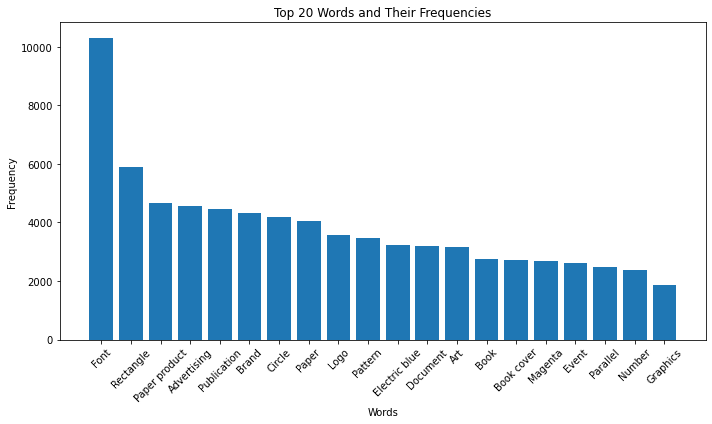

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_20_words.index, top_20_words.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words and Their Frequencies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Provide an LDA Analysis with Cover Elements

We can use Latent Dirichlet Analysis (LDA) to give an analysis of the patterns of cover design. Here, we treat the visual elements as "tokens" of "documents", and deploy this method of text analysis. Here, clusters of "documents" can be interpreted as clusters of patterns. For parallelization, I use the multicore version of LDA in gensim to finish the training

In [87]:
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

In [95]:
dictionary = corpora.Dictionary(cover_items_list)
dictionary.filter_extremes(no_below=2, no_above=0.8)
bow_corpus = [dictionary.doc2bow(text) for text in cover_items_list]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
ldamodel = models.ldamulticore.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, workers=4, passes=20,
                                            iterations=200)
# ldamodel.save('lda' + str(tpcnum) + 'p20_i400new.model')
# ldamodel = models.ldamodel.LdaModel.load('lda' + str(tpcnum) + 'p20_i400new.model')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
ldamodel.print_topics(num_words=20)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.065*"Brand" + 0.063*"Electric blue" + 0.060*"Logo" + 0.052*"Rectangle" + 0.049*"Advertising" + 0.044*"Graphics" + 0.037*"Magenta" + 0.036*"Graphic design" + 0.035*"Pattern" + 0.035*"Circle" + 0.031*"Signage" + 0.030*"Publication" + 0.020*"Event" + 0.019*"Display device" + 0.019*"Multimedia" + 0.017*"Screenshot" + 0.016*"Book cover" + 0.016*"Banner" + 0.015*"Book" + 0.014*"Darkness"'),
 (1,
  '0.101*"Monochrome photography" + 0.087*"Monochrome" + 0.080*"Paper" + 0.078*"Paper product" + 0.063*"Document" + 0.060*"Rectangle" + 0.051*"Circle" + 0.049*"Pattern" + 0.047*"Parallel" + 0.026*"Art" + 0.024*"Publication" + 0.023*"Number" + 0.021*"Newspaper" + 0.016*"Symmetry" + 0.016*"Drawing" + 0.012*"Material property" + 0.011*"Handwriting" + 0.011*"Illustration" + 0.010*"Diagram" + 0.009*"Event"'),
 (2,
  '0.110*"Paper product" + 0.101*"Rectangle" + 0.099*"Paper" + 0.092*"Document" + 0.074*"Circle" + 0.073*"Brand" + 0.072*"Parallel" + 0.068*"Number" + 0.044*"Logo" + 0.043*"Magenta" + 

In [98]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(ldamodel, bow_corpus, dictionary)
p

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.086903  0.057510       1        1  19.923718
2     -0.335402 -0.057862       2        1  17.750096
3      0.069197  0.115260       3        1  15.200938
9      0.243904 -0.193358       4        1   7.991455
8     -0.067230 -0.004937       5        1   7.968383
4      0.190889 -0.053050       6        1   7.102810
1     -0.292080 -0.093797       7        1   6.998840
7      0.133301  0.161658       8        1   6.473817
5      0.114783 -0.192397       9        1   6.232938
6      0.029540  0.260975      10        1   4.357006, topic_info=                       Term         Freq        Total Category  logprob  \
5                     Paper  3818.000000  3818.000000  Default  30.0000   
2                  Document  3030.000000  3030.000000  Default  29.0000   
6             Paper product  4416.000000  4416.000000  Default  28.0000   
7                  Parallel  2357.000000  2357.000000  Default  27.0000   
4    Monochrome photography  1044.000000  1044.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
1                    Circle   136.164124  4031.534447  Topic10  -3.8446   
152                   Label    58.651916   370.184381  Topic10  -4.6868   
24                     Logo    79.287451  3488.272528  Topic10  -4.3854   
16               Book cover    64.000707  2676.539151  Topic10  -4.5996   
0                       Art    53.335701  3123.161295  Topic10  -4.7819   

     loglift  
5    30.0000  
2    29.0000  
6    28.0000  
7    27.0000  
4    26.0000  
..       ...  
1    -0.2547  
152   1.2910  
24   -0.6507  
16   -0.6000  
0    -0.9366  

[657 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
500       8  0.974815            Abdomen
1229      1  0.910819    Accessory fruit
414       3  0.934550      Action figure
133       3  0.953600        Action film
133       6  0.007224        Action film
...     ...       ...                ...
189       6  0.064008            Writing
189       7  0.504950            Writing
189       8  0.035560            Writing
984       1  0.214775  Writing implement
984       7  0.751714  Writing implement

[1219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 10, 9, 5, 2, 8, 6, 7])